## Utilities for drawing circuits

Based on the [schemdraw](https://schemdraw.readthedocs.io/) package. Can ignore in first read

In [ ]:
!pip install schemdraw==0.14

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
import schemdraw
import schemdraw.logic as logic
import schemdraw.elements as elm

In [ ]:
def circuit_(bit, d : schemdraw.Drawing , dx=0, dy=0, drawn = {}):
  """Recursive function to draw a circuit. Gets the Bit bit and outputs the circuit used to compute it"""
  if bit in drawn:
    return drawn[bit]
  maxx = dx
  maxy = dy
  outs = []
  for c in bit.children:
    dx_ , dy_ , out = circuit_(c,d,dx,dy ,drawn)
    outs.append(out)
    maxx = max(dx_,maxx)
    maxy = max(dy_,maxy)
    dy = dy_ + 1
  maxx += 2
  x,y = maxx,maxy
  g = bit.gate(at = (x,y))
  if isinstance(g, logic.Dot):
    g.label(f"${bit.label}$")
  d += g
  for i,out in enumerate(outs):
    loc = getattr(g,f"in{i+1}") 
    d += logic.Wire().at(out).to(loc)  
  drawn[bit] =  x,y, g.out if hasattr(g,"out") else (x,y)
  return drawn[bit]

def draw_circ(*Ys):
  drawn = {}
  dx,dy = 0,0
  with schemdraw.Drawing() as d:
    d.config(unit=0.5)
    for i,y in enumerate(Ys):
      label= f"$Y_{i}$"
      x,dy_, out = circuit_(y,d,dx,dy, drawn)
      d += logic.Dot().at(out).label(label)
      dy = dy_+2


In [ ]:
import itertools
from IPython.display import Markdown, display, Math

def table(f,n):
  """Generate truth table of a function"""
  m = max(n+2,len(f.__name__)+4)
  res = "x".ljust(m) + " | " + f"{f.__name__}(x)".ljust(m) 
  res += "\n" + "-"*m+"-|-"+ "-"*m 
  
  for x in itertools.product([0,1],repeat=n):
    s = "".join([str(c) for c in x])
    res += "\n"+ s.ljust(m) + " | " + str(f(*x)).ljust(m)
  res +="\n"
  return Markdown(res)

## Class for bit operations

Inspired by the `Value` class of Karpathy, which in turn is inpired by Pytorch's `Tensor` see https://windowsontheory.org/2020/11/03/yet-another-backpropagation-tutorial/

In [ ]:
class Bit:
  """First version: without gates - just labels"""
  counter  = 0
  def __init__(self,val=0, label="-"): 
    self.label = label
    self.data = val
    self.children = []x 
  
  def op(self,f, label, *others):
    inputs = [self.data] + [o.data for o in others]
    out = Bit(f(*inputs),label)
    out.children = [self] + list(others)
    return out

  def __and__(self,other): return self.op(lambda a,b: a & b, "\\wedge", other)
  def __or__(self,other): return self.op(lambda a,b: a | b, "\\vee", other)
  def __invert__(self): return self.op(lambda a: ~a, "\\neg")

In [ ]:
class Bit:
  """Second version: with gates - just labels"""
  counter  = 0
  gates = {"\\wedge" : logic.And , "\\vee": logic.Or , "\\neg": logic.Not }
  def __init__(self,val=0, label="-"): 
    self.label = label
    self.data = val
    self.children = []
    self.gate = Bit.gates.get(label, logic.Dot)
  
  def op(self,f, label, *others):
    inputs = [self.data] + [o.data for o in others]
    out = Bit(f(*inputs),label)
    out.children = [self] + list(others)
    return out

  def __and__(self,other): return self.op(lambda a,b: a & b, "\\wedge", other)
  def __or__(self,other): return self.op(lambda a,b: a | b, "\\vee", other)
  def __invert__(self): return self.op(lambda a: ~a, "\\neg")

NameError: ignored

In [ ]:
def bits(n, label="X"): return [Bit(0,f"{label}_{i}") for i in range(n)]

## Writing a formula for bits

In [ ]:
def formula(bit):
  subformulas = [formula(c) for c in bit.children ]
  if not subformulas: return bit.label
  if len(subformulas)==1: return bit.label + " "+ subformulas[0]
  if len(subformulas)==2:
    return f"({subformulas[0]} {bit.label} {subformulas[1]})"

# Showing some operations

In [ ]:
def xor2(a,b): return (a & ~b) | (~a & b)

table(xor2,2)

x        | xor2(x) 
---------|---------
00       | 0       
01       | 1       
10       | 1       
11       | 0       


In [ ]:
Y = xor2(Bit(0,"X_0"),Bit(0,"X_1"))
Math(formula(Y)) 

<IPython.core.display.Math object>

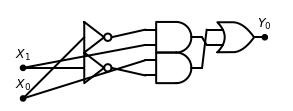

In [ ]:
draw_circ(Y)

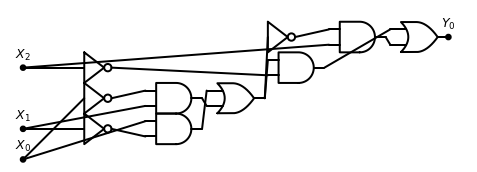

In [ ]:
def xor(*L): return xor2(*L) if len(L)==2 else xor2(xor(*L[:-1]),L[-1])
draw_circ(xor(*bits(3)))

In [ ]:
def maj(a,b,c): return (a & b) | (b&c) | (a&c)
def onebitadd(a,b,c):
  return xor(a,b,c) , maj(a,b,c)

table(onebitadd,3)

x             | onebitadd(x) 
--------------|--------------
000           | (0, 0)       
001           | (1, 0)       
010           | (1, 0)       
011           | (0, 1)       
100           | (1, 0)       
101           | (0, 1)       
110           | (0, 1)       
111           | (1, 1)       


In [ ]:
def zero(a): return a & ~a
table(zero,1)


x        | zero(x) 
---------|---------
0        | 0       
1        | 0       


In [ ]:
def maj(a,b,c): return (a & b) | (b&c) | (a&c)
def zero(a): return a & ~a
def xor2(a,b): return (a & ~b) | (~a & b)
def xor(*L): return xor2(*L) if len(L)==2 else xor2(xor(*L[:-1]),L[-1])

In [ ]:
def add(A,B): 
  """Add two binary numbers, given as lists of bits"""
  Y = []
  carry = zero(A[0]) # initialize carry to 0
  for i in range(len(A)): # compute i-th digit of output
    y = xor(A[i],B[i],carry) # xor function
    carry = maj(A[i],B[i],carry) # majority function
    Y.append(y)
  Y.append(carry)
  return Y


table(lambda a,b,c,d: add([b,a],[d,c])[::-1],4)

x            | <lambda>(x) 
-------------|-------------
0000         | [0, 0, 0]   
0001         | [0, 0, 1]   
0010         | [0, 1, 0]   
0011         | [0, 1, 1]   
0100         | [0, 0, 1]   
0101         | [0, 1, 0]   
0110         | [0, 1, 1]   
0111         | [1, 0, 0]   
1000         | [0, 1, 0]   
1001         | [0, 1, 1]   
1010         | [1, 0, 0]   
1011         | [1, 0, 1]   
1100         | [0, 1, 1]   
1101         | [1, 0, 0]   
1110         | [1, 0, 1]   
1111         | [1, 1, 0]   


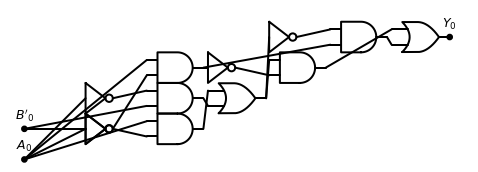

In [ ]:
X1 = bits(2, label="A")
X2 = bits(2,label="B'")
Y = add(X1,X2)
draw_circ(Y[0])

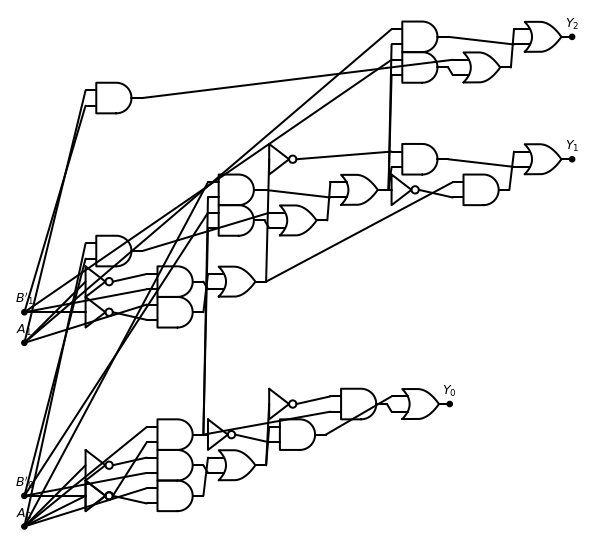

In [ ]:
draw_circ(*Y)

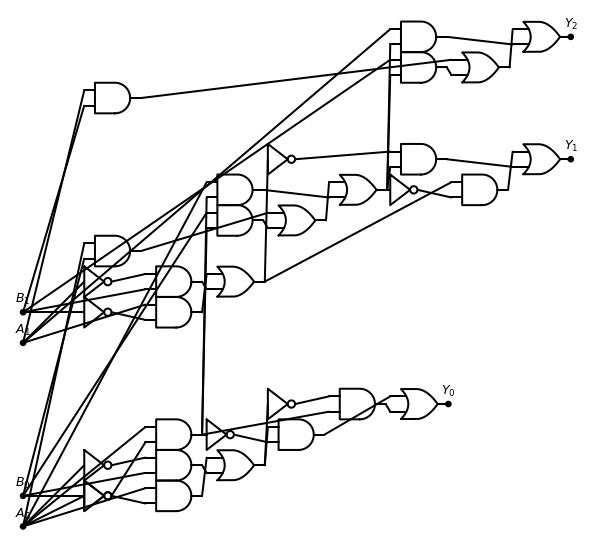

In [ ]:
A = [Bit(0,f"A_{i}") for i in range(2)]
B = [Bit(0,f"B_{i}") for i in range(2)]
draw_circ(*add(A,B))